# Stock Market Data

In [1]:
# Import libraries and dependencies
import os
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import numpy as np

%matplotlib inline

### Load environment variables and import Alpaca keys

In [2]:
# Load the environment variables by calling the load_dotenv function
load_dotenv()

True

In [3]:
# Set Alpaca API key and secret by calling the os.getenv function and referencing the environment variable names
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Check the values were imported correctly by evaluating the type of each
display(type(alpaca_api_key))
display(type(alpaca_secret_key))

str

str

### Setup REST object

In [4]:
# Create an Alpaca API REST object by calling the tradeapi.REST function
# Set the parameters to alpaca_api_key, alpaca_secret_key and api_version="v2" 
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

### Use the Alpaca SDK to make an API call

In [5]:
# Create a list of tickers for traditional (non-crypto) securities
tickers = ["DIA", "NDAQ", "SPY"]

In [6]:
# Set the values for start_date and end_date using the pd.Timestamp function
# Set this all to the ISO format by calling the isoformat function 
start_date = pd.Timestamp('2020-10-01', tz = "America/New_York").isoformat()
end_date = pd.Timestamp('2021-10-01', tz = "America/New_York").isoformat()

In [7]:
# Set timeframe to one day (1D)
timeframe = "1D"

# Set number of rows to 1000 to retrieve the maximum amount of rows
limit_rows = 1000

In [8]:
# Use the Alpaca get_barset function to gather the price information for each ticker
stock_prices = alpaca.get_barset(
    tickers,
    timeframe,
    start = start_date,
    end = end_date,
    limit = limit_rows
).df

# Keep only the date component of the DateTime index
stock_prices.index = stock_prices.index.date

# Review the first five rows of the resulting DataFrame 
display(stock_prices.head())
display(stock_prices.tail())

DIA                                     NDAQ                  \
              open    high     low   close   volume    open    high     low   
2020-10-01  279.33  280.35  276.57  278.12  2599552  123.92  124.57  122.87   
2020-10-02  274.17  278.51  273.60  276.78  4217688  122.66  124.67  122.26   
2020-10-05  278.79  281.59  278.75  281.40  1678416  124.19  124.99  122.70   
2020-10-06  282.54  283.52  277.24  277.67  4233910  124.84  125.79  123.09   
2020-10-07  280.28  283.67  280.23  282.89  2212655  123.38  124.80  122.18   

                               SPY                                      
             close  volume    open      high     low   close    volume  
2020-10-01  123.92  908229  337.69  338.7400  335.01  337.03  77057063  
2020-10-02  123.53  528313  331.70  337.0126  331.19  333.87  72797429  
2020-10-05  124.88  539675  336.06  339.9600  336.01  339.73  38540997  
2020-10-06  123.57  517618  339.92  342.1700  334.38  334.94  74231873  
2020-10-07  122.97  666336  338.12  341.6300  338.09  340.73  40579189

DIA                                     NDAQ                   \
              open    high     low   close   volume    open     high     low   
2021-09-27  348.29  350.50  348.12  348.59  2962818  196.50  196.640  194.52   
2021-09-28  347.33  347.82  342.41  342.94  6500883  193.83  194.330  189.38   
2021-09-29  343.90  345.67  342.88  343.83  3839304  191.64  194.410  190.92   
2021-09-30  345.08  345.44  338.11  338.28  7371559  195.10  197.334  192.92   
2021-10-01  340.00  344.78  337.68  343.19  5920343  194.05  194.750  190.66   

                                 SPY                                       
              close   volume    open      high     low   close     volume  
2021-09-27  195.805   814123  442.81  444.0500  441.90  442.68   51611925  
2021-09-28  190.960  1184653  439.69  440.0400  432.94  433.74  114959576  
2021-09-29  194.000   772300  435.19  437.0400  433.85  434.44   69828191  
2021-09-30  193.020   848464  436.02  436.7700  428.78  429.17  115315276  
2021-10-01  193.840   670129  430.98  436.0329  427.24  434.19  110774792

### Separate into individual DataFrames that contain only close prices

Dow Jones Industrial Average (DIA)

In [9]:
# Create DataFrame for DIA stock index
dia_prices = stock_prices["DIA"]

# Keep only the close prices
dia_df = dia_prices.drop(columns = ["open", "high", "low", "volume"])

# Display first 5 rows
dia_df.head()

,close
2020-10-01,278.12
2020-10-02,276.78
2020-10-05,281.40
2020-10-06,277.67
2020-10-07,282.89


Nasdaq (NDAQ)

In [10]:
# Create DataFrame for NDAQ stock index
ndaq_prices = stock_prices["NDAQ"]

# Keep only the close prices
ndaq_df = ndaq_prices.drop(columns = ["open", "high", "low", "volume"])

# Display first 5 rows
ndaq_df.head()

,close
2020-10-01,123.92
2020-10-02,123.53
2020-10-05,124.88
2020-10-06,123.57
2020-10-07,122.97


S&P 500 (SPY)

In [11]:
# Create DataFrame for SPY stock index
spy_prices = stock_prices["SPY"]

# Keep only the close prices
spy_df = spy_prices.drop(columns = ["open", "high", "low", "volume"])

# Display first 5 rows
spy_df.head()

,close
2020-10-01,337.03
2020-10-02,333.87
2020-10-05,339.73
2020-10-06,334.94
2020-10-07,340.73


### BOLLINGER BAND STRATEGY

In [22]:
# Create a function that generates a DataFrame of Bollinger band data for custom SMAs
def bollinger(data, window):
    
    bb_data = pd.DataFrame()
    
    # Add a column to display close prices from the called data
    bb_data["close"] = data["close"]
    
    # Use the Pandas 'rolling' and 'mean' functions to calculate an SMA based on a given window
    # Add the data to a column called 'sma'
    sma = data["close"].rolling(window = window).mean()
    bb_data["sma"] = sma
    
    # Use the Pandas 'rolling' and 'std' functions to calculate a rolling std based on a given window
    # Add the respective data to columns 'lower' and 'upper'  
    std = data["close"].rolling(window = window).std()
    bb_data["lower"] = sma - std * 1.9
    bb_data["upper"] = sma + std * 1.9
    
    print(f"Data is based on a {window}-day SMA.")
    
    return bb_data

In [23]:
# Generate a Bollinger band DataFrame for SPY. Play around with differetn values for 'window'.
spy_bb = bollinger(spy_df, 10)

# Display DataFrame
spy_bb

Data is based on a 10-day SMA.


,close,sma,lower,upper
2020-10-01,337.03,NaN,NaN,NaN
2020-10-02,333.87,NaN,NaN,NaN
2020-10-05,339.73,NaN,NaN,NaN
2020-10-06,334.94,NaN,NaN,NaN
2020-10-07,340.73,NaN,NaN,NaN
...,...,...,...,...
2021-09-27,442.68,441.590,432.209301,450.970699
2021-09-28,433.74,440.546,430.267263,450.824737
2021-09-29,434.44,439.203,429.618819,448.787181
2021-09-30,429.17,437.406,427.710036,447.101964


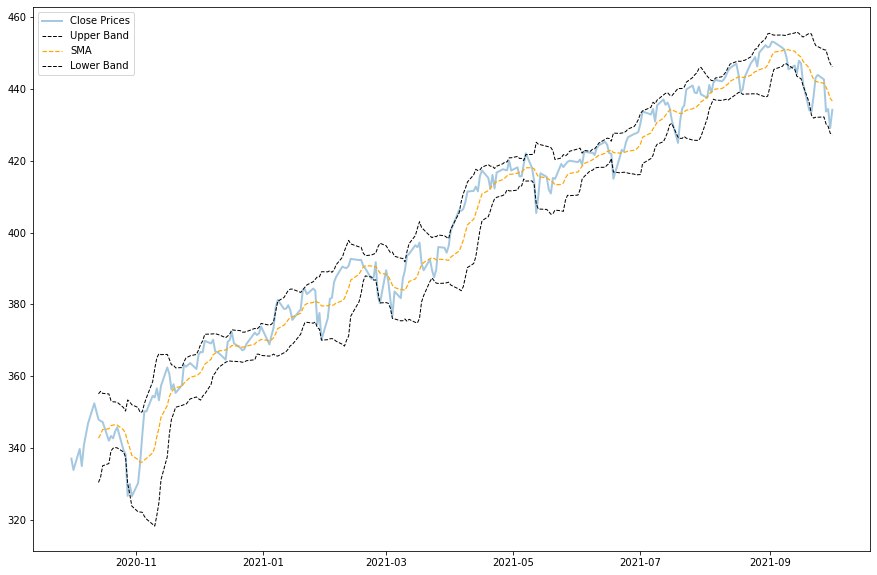

In [41]:
# Plot the DataFrame to visualize the SMA and Bollinger bands using axes objects (ax=ax)
ax = spy_bb['close'].plot(figsize = (15,10), alpha = 0.4, linewidth = 2)

# Overlay each column as a separate line on the same plot
spy_bb['upper'].plot(ax=ax, linestyle = '--', linewidth = 1, color = 'black')
spy_bb['sma'].plot(ax=ax, linestyle = '--', linewidth = 1.2, color = 'orange')
spy_bb['lower'].plot(ax=ax, linestyle = '--', linewidth = 1, color = 'black')

# Call the legend for the plot
ax.legend(["Close Prices", "Upper Band", "SMA", "Lower Band"])

In [15]:
# Generate a Bollinger band DataFrame for NDAQ. Play around with differetn values for 'window'.
ndaq_bb = bollinger(ndaq_df, 20)

# Display DataFrame
ndaq_bb

Data is based on a 20-day SMA.


,close,sma,lower,upper
2020-10-01,123.920,NaN,NaN,NaN
2020-10-02,123.530,NaN,NaN,NaN
2020-10-05,124.880,NaN,NaN,NaN
2020-10-06,123.570,NaN,NaN,NaN
2020-10-07,122.970,NaN,NaN,NaN
...,...,...,...,...
2021-09-27,195.805,195.66675,191.479461,199.854039
2021-09-28,190.960,195.50975,190.864675,200.154825
2021-09-29,194.000,195.42025,190.729160,200.111340
2021-09-30,193.020,195.17175,190.527510,199.815990


<AxesSubplot:>

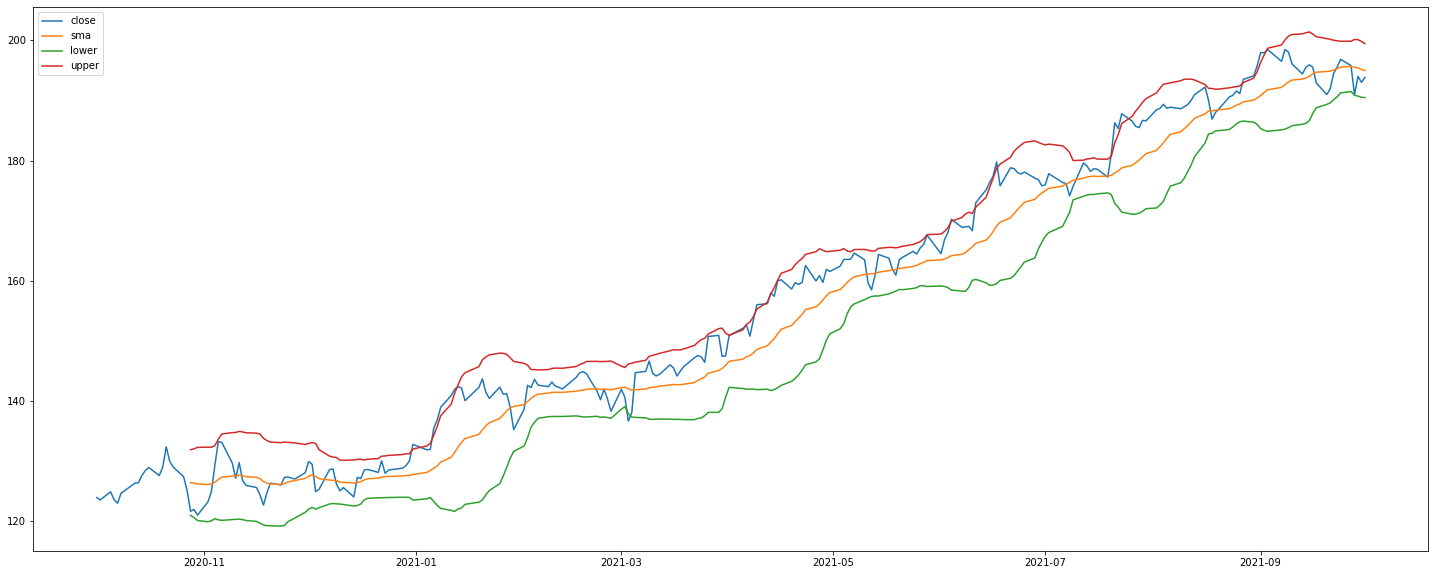

In [16]:
# Plot the DataFrame to visualize the SMA and Bollinger bands
ndaq_bb.plot(figsize=(25,10))

In [17]:
# Generate a Bollinger band DataFrame for NDAQ. Play around with differetn values for 'window'.
dia_bb = bollinger(dia_df, 20)

# Display DataFrame
dia_bb

Data is based on a 20-day SMA.


,close,sma,lower,upper
2020-10-01,278.12,NaN,NaN,NaN
2020-10-02,276.78,NaN,NaN,NaN
2020-10-05,281.40,NaN,NaN,NaN
2020-10-06,277.67,NaN,NaN,NaN
2020-10-07,282.89,NaN,NaN,NaN
...,...,...,...,...
2021-09-27,348.59,348.621,339.485298,357.756702
2021-09-28,342.94,348.062,338.974992,357.149008
2021-09-29,343.83,347.559,338.719981,356.398019
2021-09-30,338.28,346.794,337.511849,356.076151


<AxesSubplot:>

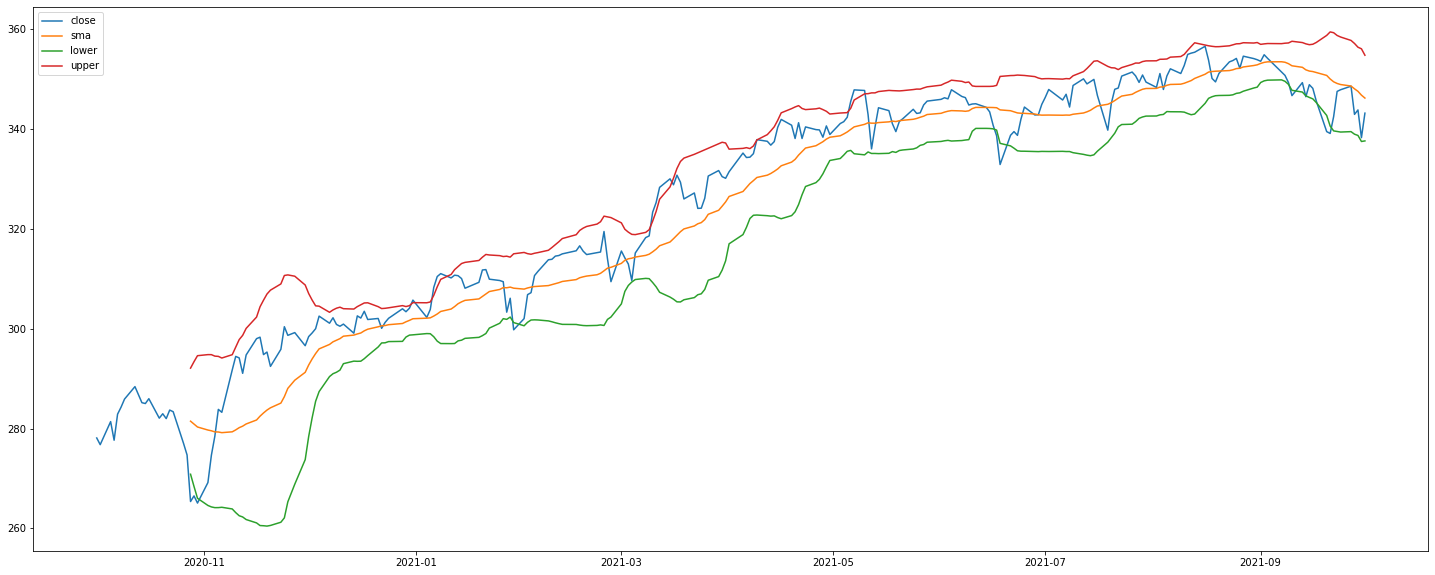

In [19]:
# Plot the DataFrame to visualize the SMA and Bollinger bands
dia_bb.plot(figsize=(25,10))